https://www.kaggle.com/datasets/putdejudomthai/ecommerce-ab-testing-2022-dataset1/data
https://medium.com/vptech/introduction-to-bayesian-a-b-testing-in-python-df81a9b3f5fd

 The company has developed a new web page in order to try and increase the number of users who "convert," 
 meaning the number of users who decide to pay for the company's product. Your goal is to work through this 
 notebook to help the company understand if they should implement this new page, keep the old page, or perhaps
 run the experiment longer to make their decision.

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from scipy.stats import ttest_ind

## Using All Samples

The Control group navigates to the old page while the variant navigates to the variant

In [9]:
def getData(group, countryInd, countryName):
    df = pd.read_csv("/Users/mattmacrides/Personal-Projects/AB Testing (Statistics)/Data/ab_data.csv")
    countries = pd.read_csv("/Users/mattmacrides/Personal-Projects/AB Testing (Statistics)/Data/countries.csv")

    # Drop Duplicates
    df = df.drop_duplicates(subset='user_id', keep='first')
    #Merge with country data
    df = pd.merge(df, countries, on = 'user_id', how = 'inner')

    # Create a DataFrame for the 'X' group
    segment = df[df['group'] == group]

    if countryInd == True:
        segment = df[df['group'] == group]
        segment = segment[segment['country'] == countryName]
        array = segment['converted'].to_numpy()
    else:
        # Create arrays for the 'Converted' column in each group
        array = segment['converted'].to_numpy()

    return array

In [10]:
def GetStatistics(control, variant):
    # Descriptive Statistics
    n_control = len(control)
    n_variant = len(variant)

    mean_control = np.mean(control).round(4)
    mean_variant = np.mean(variant).round(4)

    median_control = np.median(control)
    median_variant = np.median(variant)

    std_dev_control = np.std(control).round(4)
    std_dev_variant = np.std(variant).round(4)

    var_control = np.var(control).round(4)
    var_variant = np.var(variant).round(4)

    print("                                Descriptive Statistics:")
    print("|--------------------------------------------------------------------------------------|")
    print(f"| The size of the Control group is: {n_control}  | The size of the Variant group is: {n_variant} |")
    print(f"| Mean Control: {mean_control}                      | Mean Variant: {mean_variant}                     |")
    print(f"| Median Control: {median_control}                       | Median Variant: {median_variant}                      |")
    print(f"| Standard Deviation Control: {std_dev_control}        | Standard Deviation Variant: {std_dev_variant}       |")
    print(f"| Variance Control: {var_control}                  | Variance Variant: {var_variant}                 |")
    print("|--------------------------------------------------------------------------------------|")

    return mean_control


In [11]:
def meanDifference(control, variant):
    mean_difference = variant.mean() - control.mean()
    return mean_difference.round(4)

In [12]:
def resize(control, variant, probability):
    # Resize the control group to match the size of the variant group
    new_control = np.random.choice(
        a = np.unique(control),
        size=len(variant),
        replace=True,  # Use replacement for resize
        p=[probability, 1 - probability]
    )
    
    n_control = len(new_control)
    n_variant = len(variant)
    print(f"| The size of the Control group is: {n_control}  | The size of the Variant group is: {n_variant} |")

    return new_control

In [13]:
def evaluate(control, variant):
    # Perform independent samples t-test
    t_stat, p_value = ttest_ind(variant, control, alternative='two-sided')

    # Calculate standard error of the difference in means
    std_error = np.sqrt((np.var(control) / len(control)) + (np.var(variant) / len(variant)))

    # Calculate margin of error for a 95% confidence interval
    margin_of_error = 1.96 * std_error  # 1.96 corresponds to the critical value for a 95% CI

    # Calculate the confidence interval
    mean_difference = variant.mean() - control.mean()
    lower_bound = mean_difference - margin_of_error
    upper_bound = mean_difference + margin_of_error

    # Display results
    print("                       Results:")
    print("|------------------------------------------------------|")
    print("| Mean Difference:                  ", mean_difference.round(4), "          |")
    print("| 95% Confidence Interval:          ", (lower_bound.round(4), upper_bound.round(4)), "|")
    print("| Test Statistic:                   ", t_stat.round(4), "          |")
    print("| P-value:                          ", p_value.round(4), "           |")

    # Evaluate significance
    alpha = 0.05
    is_significant = (p_value < alpha)

    print("| Is Significant (at alpha = 0.05): ", is_significant, "            |")
    print("|------------------------------------------------------|")

In [14]:
control = getData('control', countryInd=False, countryName='')
variant = getData('treatment', countryInd=False, countryName='')
probability = GetStatistics(control, variant)

                                Descriptive Statistics:
|--------------------------------------------------------------------------------------|
| The size of the Control group is: 145232  | The size of the Variant group is: 145354 |
| Mean Control: 0.1203                      | Mean Variant: 0.1188                     |
| Median Control: 0.0                       | Median Variant: 0.0                      |
| Standard Deviation Control: 0.3253        | Standard Deviation Variant: 0.3236       |
| Variance Control: 0.1058                  | Variance Variant: 0.1047                 |
|--------------------------------------------------------------------------------------|


The control group has .05% more users than the variant group. Even though this is likely to be insignificant, lets downsample the control group so that it matches the variant group exactly

In [15]:
new_control = resize(control, variant, probability)

| The size of the Control group is: 145354  | The size of the Variant group is: 145354 |


Now the size of the control and variant groups are the same

Is the conversion rate significantly different across groups?

Null Hypothesis: There is no difference in the mean outcome between the control group and the variant group

Alternate Hypothesis: The mean outcome in the variant group is not equal to the mean outcome in the control group

In [16]:
evaluate(control, variant)

                       Results:
|------------------------------------------------------|
| Mean Difference:                   -0.0015           |
| 95% Confidence Interval:           (-0.0038, 0.0009) |
| Test Statistic:                    -1.2097           |
| P-value:                           0.2264            |
| Is Significant (at alpha = 0.05):  False             |
|------------------------------------------------------|


Conclusion: The difference in conversion rates between the new page and the old page is not statistically significant. Management should reassess what they believe retains customers.

## Stratify Samples Based on Country

In [17]:
# Find the Countries with the highest Freqs
countries = pd.read_csv("/Users/mattmacrides/Personal-Projects/AB Testing (Statistics)/Data/countries.csv")
countries['country'].value_counts()

country
US    203621
UK     72466
CA     14499
Name: count, dtype: int64

Let's stratify based on all three countries

### United States

In [18]:
control = getData('control', countryInd=True, countryName = 'US')
variant = getData('treatment', countryInd=True, countryName = 'US')
probabilityUS = GetStatistics(control, variant)
mdUS = meanDifference(control, variant)

                                Descriptive Statistics:
|--------------------------------------------------------------------------------------|
| The size of the Control group is: 101691  | The size of the Variant group is: 101930 |
| Mean Control: 0.1205                      | Mean Variant: 0.1185                     |
| Median Control: 0.0                       | Median Variant: 0.0                      |
| Standard Deviation Control: 0.3255        | Standard Deviation Variant: 0.3232       |
| Variance Control: 0.106                  | Variance Variant: 0.1045                 |
|--------------------------------------------------------------------------------------|


In [19]:
new_control = resize(control, variant, probabilityUS)

| The size of the Control group is: 101930  | The size of the Variant group is: 101930 |


In [20]:
evaluate(control, variant)

                       Results:
|------------------------------------------------------|
| Mean Difference:                   -0.0019           |
| 95% Confidence Interval:           (-0.0047, 0.0009) |
| Test Statistic:                    -1.336           |
| P-value:                           0.1815            |
| Is Significant (at alpha = 0.05):  False             |
|------------------------------------------------------|


Conclusion: The difference in conversion rates between the new page and the old page in the United States is not statistically significant. Stratifying by country did not make a difference.

### United Kingdom

In [21]:
control = getData('control', countryInd=True, countryName = 'UK')
variant = getData('treatment', countryInd=True, countryName = 'UK')
probabilityUK = GetStatistics(control, variant)
mdUK = meanDifference(control, variant)

                                Descriptive Statistics:
|--------------------------------------------------------------------------------------|
| The size of the Control group is: 36352  | The size of the Variant group is: 36114 |
| Mean Control: 0.1201                      | Mean Variant: 0.121                     |
| Median Control: 0.0                       | Median Variant: 0.0                      |
| Standard Deviation Control: 0.3251        | Standard Deviation Variant: 0.3261       |
| Variance Control: 0.1057                  | Variance Variant: 0.1063                 |
|--------------------------------------------------------------------------------------|


In [22]:
new_control = resize(control, variant, probabilityUK)

| The size of the Control group is: 36114  | The size of the Variant group is: 36114 |


In [23]:
evaluate(control, variant)

                       Results:
|------------------------------------------------------|
| Mean Difference:                   0.0008           |
| 95% Confidence Interval:           (-0.0039, 0.0056) |
| Test Statistic:                    0.3501           |
| P-value:                           0.7263            |
| Is Significant (at alpha = 0.05):  False             |
|------------------------------------------------------|


Conclusion: The difference in conversion rates between the new page and the old page in the United Kingdom is not statistically significant. Stratifying by country did not make a difference.

### Canada

In [24]:
control = getData('control', countryInd=True, countryName = 'CA')
variant = getData('treatment', countryInd=True, countryName = 'CA')
probabilityCA = GetStatistics(control, variant)
mdCA = meanDifference(control, variant)

                                Descriptive Statistics:
|--------------------------------------------------------------------------------------|
| The size of the Control group is: 7189  | The size of the Variant group is: 7310 |
| Mean Control: 0.1189                      | Mean Variant: 0.1126                     |
| Median Control: 0.0                       | Median Variant: 0.0                      |
| Standard Deviation Control: 0.3237        | Standard Deviation Variant: 0.3161       |
| Variance Control: 0.1048                  | Variance Variant: 0.0999                 |
|--------------------------------------------------------------------------------------|


In [25]:
new_control = resize(control, variant, probabilityCA)

| The size of the Control group is: 7310  | The size of the Variant group is: 7310 |


In [26]:
evaluate(control, variant)

                       Results:
|------------------------------------------------------|
| Mean Difference:                   -0.0063           |
| 95% Confidence Interval:           (-0.0168, 0.0041) |
| Test Statistic:                    -1.1943           |
| P-value:                           0.2324            |
| Is Significant (at alpha = 0.05):  False             |
|------------------------------------------------------|


Conclusion: The difference in conversion rates between the new page and the old page in the Canada is not statistically significant. Stratifying by country did not make a difference.

## Appendix

### Country Frequencies

Text(0.5, 1.0, 'Value Counts of Unique Values in Your Column')

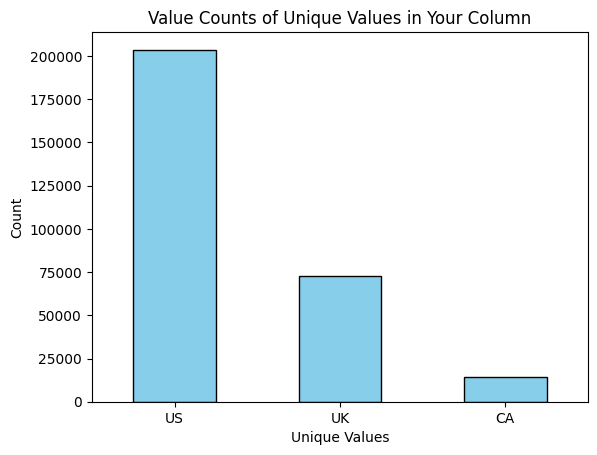

In [27]:
import matplotlib.pyplot as plt
# Get the value counts

value_counts = countries['country'].value_counts()

# Plot the value counts
value_counts.plot(kind='bar', rot=0, color='skyblue', edgecolor='black')

# Set labels and title
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Value Counts of Unique Values in Your Column')

### Country Mean Difference

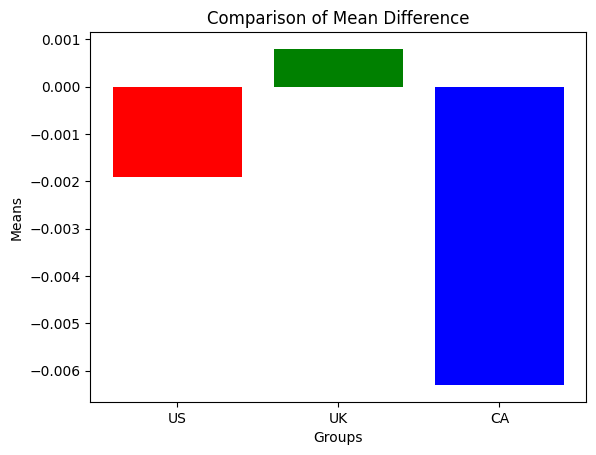

In [28]:
# Names for the bars (replace with meaningful labels)
labels = ['US', 'UK', 'CA']

# Values for the bars
values = [mdUS, mdUK, mdCA]

# Create a bar plot
plt.bar(labels, values, color=['red', 'green', 'blue'])

# Set labels and title
plt.xlabel('Groups')
plt.ylabel('Means')
plt.title('Comparison of Mean Difference')

# Show the plot
plt.show()

Notice that besides the UK, the groups actually have observed less conversion rates from the old page to the new page